# Capstone week 4 and 5 project: analyze which neighborhood to open a new Chinese restaurant in Queens borough, New York City

## Introduction<br> 
**Problem to Solve**:<br>
We all know that US is an immigrant country. There are very many people come to settle in US every year. How to make a living is a question every new immigrant faces. A lot of Chinese immigrants like to open their new businesses. Chinese restaurant is an obvious option to a lot of them. However, in the new environment, it is not that easy to know where to open a new Chinese restaurant. In this project, I tried to analyze the data available to offer recommendations where to open a new Chinese restaurant in the neighborhoods of Queens, New York City.<br>
**Data:**<br>
I will get the venu data of Queens neighborhoods from Foursquare and the annual average population of Queens neighborhoods from the official website of New York's Department of Health (https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm). <br>
However, both Foursquare the Department of Health of New York City provide very limited data about restaurants, detailed distributions of people from different ethnics and so on. And the information is not easy to get from other sources. Using the current available data, I will try my best to analyze the data and visulize the results to offer recommendations to people who want to open a new restaurant in Queens neighborhoods.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.0               |             py_0         606 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

## Get the location data of the New York City

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


## Retrive the features of new york boroughs

In [7]:
neighborhoods_data = newyork_data['features']

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
queens_ny=neighborhoods.loc[neighborhoods['Borough'] == 'Queens']
queens_ny=queens_ny.reset_index(drop=True)
queens_ny.columns
queens_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


## Get the location data of Queens borough

In [11]:
address = 'Queens, New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Queens borough of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Queens borough of New York City are 40.7498243, -73.7976337.


In [12]:
# create map of Queens using latitude and longitude values
map_queens = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(queens_ny['Latitude'], queens_ny['Longitude'], queens_ny['Borough'], queens_ny['Neighborhood']):
    label = '{}, {}'.format(queens_ny, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_queens)  
    
map_queens

## User credencials accessing the venu info of Queens on Foursquare

In [13]:
CLIENT_ID = '1LFVRZ351MSJGMUVYZEYIMTIN2BY2V5AU5WRA1HWWWAMODJ4' # your Foursquare ID
CLIENT_SECRET = 'FHJBRKSNHCP1QM32R5OMWSN0DIEDGCIHFVUBIXCVMKJOT5UG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1LFVRZ351MSJGMUVYZEYIMTIN2BY2V5AU5WRA1HWWWAMODJ4
CLIENT_SECRET:FHJBRKSNHCP1QM32R5OMWSN0DIEDGCIHFVUBIXCVMKJOT5UG


Let's explore the first neighborhood in Queens.

In [14]:
queens_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


In [15]:
neighborhood_latitude = queens_ny.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = queens_ny.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = queens_ny.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Astoria are 40.76850859335492, -73.91565374304234.


## Now, let's get the top 100 venues that are in Astoria within a radius of 500 meters.
## First, let's create the GET request URL. Name your URL url.

In [16]:
LIMIT=100
radius=500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=1LFVRZ351MSJGMUVYZEYIMTIN2BY2V5AU5WRA1HWWWAMODJ4&client_secret=FHJBRKSNHCP1QM32R5OMWSN0DIEDGCIHFVUBIXCVMKJOT5UG&v=20180605&ll=40.76850859335492,-73.91565374304234&radius=500&limit=100'

In [17]:
results = requests.get(url).json()

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Get the venus in Queens

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,King Souvlaki of Astoria,Food Truck,40.769683,-73.915128
1,Favela Grill,Brazilian Restaurant,40.767348,-73.917897
2,Orange Blossom,Gourmet Shop,40.769856,-73.917012
3,Titan Foods Inc.,Gourmet Shop,40.769198,-73.919253
4,CrossFit Queens,Gym,40.769404,-73.918977


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## Explore Neighborhoods in Queens

Let's create a function to repeat the same process to all the neighborhoods in Queens

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Now write the code to run the above function on each neighborhood and create a new dataframe called queens_venues.

In [22]:
queens_venues = getNearbyVenues(names=queens_ny['Neighborhood'],
                                   latitudes=queens_ny['Latitude'],
                                   longitudes=queens_ny['Longitude']
                                  )

Astoria
Woodside
Jackson Heights
Elmhurst
Howard Beach
Corona
Forest Hills
Kew Gardens
Richmond Hill
Flushing
Long Island City
Sunnyside
East Elmhurst
Maspeth
Ridgewood
Glendale
Rego Park
Woodhaven
Ozone Park
South Ozone Park
College Point
Whitestone
Bayside
Auburndale
Little Neck
Douglaston
Glen Oaks
Bellerose
Kew Gardens Hills
Fresh Meadows
Briarwood
Jamaica Center
Oakland Gardens
Queens Village
Hollis
South Jamaica
St. Albans
Rochdale
Springfield Gardens
Cambria Heights
Rosedale
Far Rockaway
Broad Channel
Breezy Point
Steinway
Beechhurst
Bay Terrace
Edgemere
Arverne
Rockaway Beach
Neponsit
Murray Hill
Floral Park
Holliswood
Jamaica Estates
Queensboro Hill
Hillcrest
Ravenswood
Lindenwood
Laurelton
Lefrak City
Belle Harbor
Rockaway Park
Somerville
Brookville
Bellaire
North Corona
Forest Hills Gardens
Jamaica Hills
Utopia
Pomonok
Astoria Heights
Hunters Point
Sunnyside Gardens
Blissville
Roxbury
Middle Village
Malba
Hammels
Bayswater
Queensbridge


In [23]:
print(queens_venues.shape)
queens_venues.head()

(2104, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,King Souvlaki of Astoria,40.769683,-73.915128,Food Truck
1,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
2,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
3,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
4,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym


## Let's check how many venues were returned for each neighborhood

In [24]:
print(queens_venues.groupby('Neighborhood').count().shape) # There are 81 Neighborhoods generated by Foursquare. 
                                                           # However, we will need to adjust them to make it conform to the Queens neighborhoods on the official website of the 
                                                           # Department of Health of New York City.
queens_venues.groupby('Neighborhood').count()

(81, 6)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arverne,18,18,18,18,18,18
Astoria,100,100,100,100,100,100
Astoria Heights,13,13,13,13,13,13
Auburndale,19,19,19,19,19,19
Bay Terrace,37,37,37,37,37,37
Bayside,74,74,74,74,74,74
Bayswater,3,3,3,3,3,3
Beechhurst,12,12,12,12,12,12
Bellaire,11,11,11,11,11,11


## Let's find out how many unique categories can be curated from all the returned venues

In [25]:
print('There are {} uniques categories.'.format(len(queens_venues['Venue Category'].unique())))

There are 274 uniques categories.


## Analyze Each Neighborhood
We can see from the results that not all columns are of our interests. There are totally 269 columns. We are only insterested in the columns of restaurants. Furthermore, 
we are more interested in east Asian restaurant. More would be explained later.

In [26]:
# one hot encoding
queens_onehot = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_onehot['Neighborhood'] = queens_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = queens_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
queens_onehot = queens_onehot.reindex(columns= cols)

print(queens_onehot.shape)
queens_onehot.head()

(2104, 274)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Garden,Bike Trail,Bistro,Board Shop,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Cafeteria,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Post Office,Pub,Ramen Restaurant,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Romanian Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine

## Filter the venus in Queens's neighborhoods to get a dataset with all east Asian restaurants.
Since Chinese restaurant's competitors are mostly from east Asia, I would only keep the columns of east Asian restaurants in Queens neighborhoods. After filtering the restaurants, I have 14 columns which represent 14 kinds of restaurants from different areas of east Asia.

In [27]:
# Filter the venus to get all restaurants in Queens's neighborhoods
temp=queens_onehot['Neighborhood']
queens_restaurants=queens_onehot.filter(regex='Restaurant')
queens_restaurants['Neighborhood']=temp
# move neighborhood column to the first column
cols = queens_restaurants.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))
queens_restaurants = queens_restaurants.reindex(columns= cols)
print(queens_restaurants.shape)
queens_restaurants.head()

(2104, 62)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
queens_restaurants=queens_restaurants.groupby('Neighborhood').sum()
print(queens_restaurants.shape)
queens_restaurants.head()

(81, 61)


,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Halal Restaurant,Himalayan Restaurant,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,North Indian Restaurant,Peruvian Restaurant,Polish Restaurant,Ramen Restaurant,Restaurant,Romanian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arverne,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Astoria,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0,2,0,2,2,1,0,2,0,3,1,5,0,0,0,0,0,0,0,4,0,0,0,0,0,1,0,0,0,1,0,0,1,0
Astoria Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Auburndale,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
Bay Terrace,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Further filter the venus to get all  east Asian restaurants in Queens's neighborhoods
queens_asian_restaurants = queens_restaurants[['Cantonese Restaurant','Chinese Restaurant','Dim Sum Restaurant','Dumpling Restaurant','Filipino Restaurant','Hotpot Restaurant','Indonesian Restaurant','Japanese Restaurant','Korean Restaurant','Malay Restaurant','Shanghai Restaurant','Szechuan Restaurant','Taiwanese Restaurant','Vietnamese Restaurant']]
                                            

In [30]:
print(queens_asian_restaurants.shape)
queens_asian_restaurants

(81, 14)


,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Filipino Restaurant,Hotpot Restaurant,Indonesian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Vietnamese Restaurant
Neighborhood,,,,,,,,,,,,,,
Arverne,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Astoria,0,1,0,0,0,0,0,2,1,0,0,0,0,0
Astoria Heights,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Auburndale,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Bay Terrace,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bayside,0,0,0,0,0,0,0,0,1,0,1,0,0,1
Bayswater,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Beechhurst,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Bellaire,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
queens_asian_restaurants.columns

Index(['Cantonese Restaurant', 'Chinese Restaurant', 'Dim Sum Restaurant',
       'Dumpling Restaurant', 'Filipino Restaurant', 'Hotpot Restaurant',
       'Indonesian Restaurant', 'Japanese Restaurant', 'Korean Restaurant',
       'Malay Restaurant', 'Shanghai Restaurant', 'Szechuan Restaurant',
       'Taiwanese Restaurant', 'Vietnamese Restaurant'],
      dtype='object')

## Adjust the dataframe of Queens_asian_restaurants according to the neighborhoods on the official website of the Department of Health of New York City (https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm.)
The table below is the snapshot of the population of each neighborhood in Queens. There are totally 14 neighborhoods. Since this is the official neighborhoods on government's website, I will adjust my dataset to conform to this table. The right most column is the population of each neighborhood of Queens. I will analyze the relationship of population and the number Chinese and east Asian restaurants.
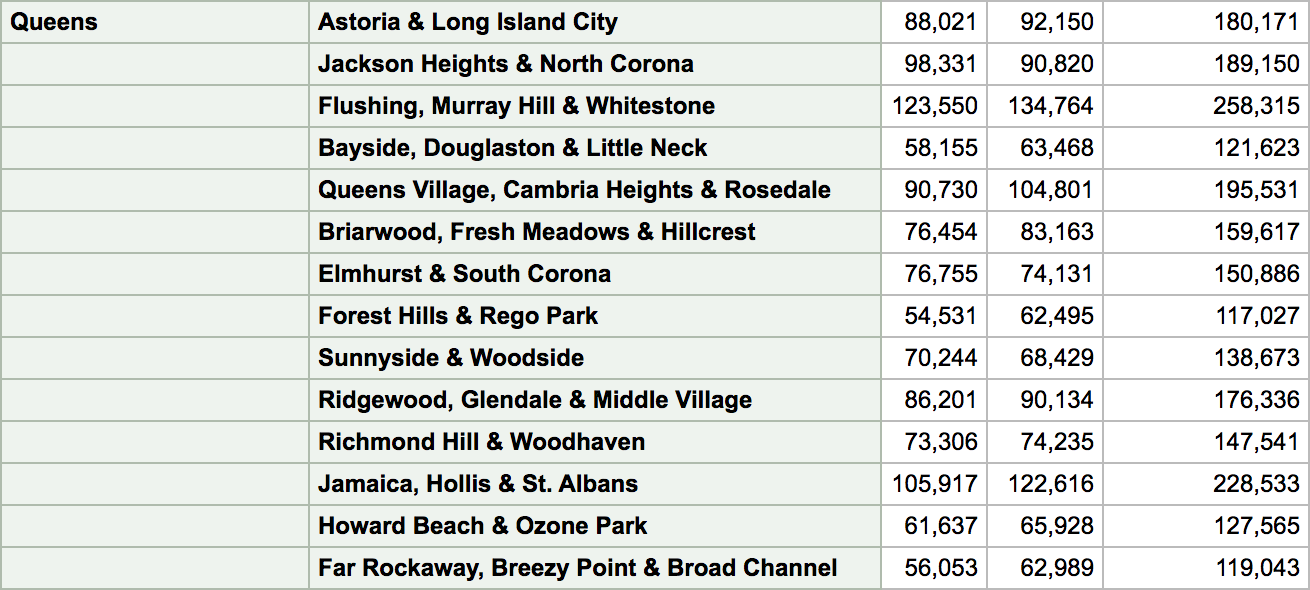

In [32]:
#Create the dataframe that the neighborhoods conform to the table shown above
queens_14neighborhoods_asian_restaurants=pd.DataFrame(columns=queens_asian_restaurants.columns)
queens_14neighborhoods_asian_restaurants.columns
queens_14neighborhoods_asian_restaurants.loc['Astoria, Astoria Height, Long Island City'] = queens_asian_restaurants.loc['Astoria'] \
                                                                                  + queens_asian_restaurants.loc['Astoria Heights'] \
                                                                                      + queens_asian_restaurants.loc['Long Island City'] 
queens_14neighborhoods_asian_restaurants.loc['Jackson Heights, Corona'] = queens_asian_restaurants.loc['Jackson Heights'] \
                                                                                      + queens_asian_restaurants.loc['Corona']                                          
queens_14neighborhoods_asian_restaurants.loc['Flushing, Murray Hill, Whitestone'] = queens_asian_restaurants.loc['Flushing'] \
                                                                                      + queens_asian_restaurants.loc['Murray Hill'] \
                                                                                      + queens_asian_restaurants.loc['Whitestone']
queens_14neighborhoods_asian_restaurants.loc['Bayside, Douglaston, Little Neck'] = queens_asian_restaurants.loc['Bayside'] \
                                                                                      + queens_asian_restaurants.loc['Douglaston'] \
                                                                                      + queens_asian_restaurants.loc['Little Neck']
queens_14neighborhoods_asian_restaurants.loc['Queens Village, Cambria Heights, Rosedale'] = queens_asian_restaurants.loc['Queens Village'] \
                                                                                      + queens_asian_restaurants.loc['Cambria Heights'] \
                                                                                      + queens_asian_restaurants.loc['Rosedale']
queens_14neighborhoods_asian_restaurants.loc['Briarwood, Fresh Meadows & Hillcrest'] = queens_asian_restaurants.loc['Briarwood'] \
                                                                                      + queens_asian_restaurants.loc['Fresh Meadows'] \
                                                                                      + queens_asian_restaurants.loc['Hillcrest']
queens_14neighborhoods_asian_restaurants.loc['Elmhurst, East Elmhurst'] = queens_asian_restaurants.loc['Elmhurst'] \
                                                                                      + queens_asian_restaurants.loc['East Elmhurst'] 
queens_14neighborhoods_asian_restaurants.loc['Forest Hills, Rego Park'] = queens_asian_restaurants.loc['Forest Hills'] \
                                                                                      + queens_asian_restaurants.loc['Rego Park'] 
queens_14neighborhoods_asian_restaurants.loc['Forest Hills, Rego Park'] = queens_asian_restaurants.loc['Forest Hills'] \
                                                                                      + queens_asian_restaurants.loc['Rego Park']
queens_14neighborhoods_asian_restaurants.loc['Sunnyside, Woodside'] = queens_asian_restaurants.loc['Sunnyside'] \
                                                                                      + queens_asian_restaurants.loc['Woodside']  
queens_14neighborhoods_asian_restaurants.loc['Ridgewood, Glendale, Middle Village'] = queens_asian_restaurants.loc['Ridgewood'] \
                                                                                      + queens_asian_restaurants.loc['Glendale']  \
                                                                                      + queens_asian_restaurants.loc['Middle Village']
queens_14neighborhoods_asian_restaurants.loc['Richmond Hill, Woodhaven'] = queens_asian_restaurants.loc['Richmond Hill'] \
                                                                                      + queens_asian_restaurants.loc['Woodhaven']
queens_14neighborhoods_asian_restaurants.loc['Jamaica, Hollis, St. Albans'] = queens_asian_restaurants.loc['Jamaica Center'] \
                                                                                      + queens_asian_restaurants.loc['Jamaica Estates']  \
                                                                                      + queens_asian_restaurants.loc['Jamaica Estates']  \
                                                                                      + queens_asian_restaurants.loc['Hollis']  \
                                                                                      + queens_asian_restaurants.loc['St. Albans']
queens_14neighborhoods_asian_restaurants.loc['Howard Beach, Ozone Park'] = queens_asian_restaurants.loc['Howard Beach'] \
                                                                                      + queens_asian_restaurants.loc['Ozone Park'] 
queens_14neighborhoods_asian_restaurants.loc['Far Rockaway, Breezy Point, Broad Channel'] = queens_asian_restaurants.loc['Far Rockaway'] \
                                                                                      + queens_asian_restaurants.loc['Breezy Point']  \
                                                                                      + queens_asian_restaurants.loc['Broad Channel']

In [33]:
queens_14neighborhoods_asian_restaurants.columns

Index(['Cantonese Restaurant', 'Chinese Restaurant', 'Dim Sum Restaurant',
       'Dumpling Restaurant', 'Filipino Restaurant', 'Hotpot Restaurant',
       'Indonesian Restaurant', 'Japanese Restaurant', 'Korean Restaurant',
       'Malay Restaurant', 'Shanghai Restaurant', 'Szechuan Restaurant',
       'Taiwanese Restaurant', 'Vietnamese Restaurant'],
      dtype='object')

In [34]:
queens_14neighborhoods_asian_restaurants.shape # This conforms to the 14 neighborhoods on https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm.

(14, 14)

## Add the population of each neighborhood to the dataframe with a new column 'Population'

In [35]:
queens_14neighborhoods_asian_restaurants['Population'] = [180171,189150,258315,121623,195531,159617,150886,117027,138673,176336,147541,228533,127565,119043]
queens_14neighborhoods_asian_restaurants['Total Restaurant'] = 0
queens_14neighborhoods_asian_restaurants['Total Restaurant'] = queens_14neighborhoods_asian_restaurants[['Cantonese Restaurant', 'Chinese Restaurant', 'Dim Sum Restaurant',
'Dumpling Restaurant', 'Filipino Restaurant', 'Hotpot Restaurant','Indonesian Restaurant', 'Japanese Restaurant', 'Korean Restaurant','Malay Restaurant', 'Shanghai Restaurant', 'Szechuan Restaurant','Taiwanese Restaurant', 'Vietnamese Restaurant']].sum(axis=1)

In [36]:
queens_14neighborhoods_asian_restaurants.index.name='Neighborhood'
queens_14neighborhoods_asian_restaurants

,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Filipino Restaurant,Hotpot Restaurant,Indonesian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Vietnamese Restaurant,Population,Total Restaurant
Neighborhood,,,,,,,,,,,,,,,,
"Astoria, Astoria Height, Long Island City",0,3,0,0,0,0,0,2,1,0,0,0,0,0,180171,6
"Jackson Heights, Corona",0,0,0,0,0,0,0,0,0,0,0,0,0,0,189150,0
"Flushing, Murray Hill, Whitestone",1,3,1,1,0,6,0,1,26,1,1,2,0,0,258315,43
"Bayside, Douglaston, Little Neck",1,5,0,0,0,0,0,1,4,0,2,0,0,2,121623,15
"Queens Village, Cambria Heights, Rosedale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,195531,0
"Briarwood, Fresh Meadows & Hillcrest",0,2,1,0,0,0,0,0,0,0,0,0,0,0,159617,3
"Elmhurst, East Elmhurst",0,3,0,0,0,1,1,0,0,1,0,0,0,2,150886,8
"Forest Hills, Rego Park",0,3,0,0,0,0,0,1,0,0,1,0,0,0,117027,5
"Sunnyside, Woodside",0,5,0,0,4,0,0,1,0,0,0,0,0,0,138673,10


## Data visulization and analysis <br>
I plot the relationship of Chinese restaurant and population, total east Asian restaurant and population, and the density of Chinese restaurant among east Asian restaurants and the population to analyze which neighbood is good to open a new Chinese restaurant.

In [37]:
%matplotlib inline 
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression

## The following plot shows the number of Chinese restaurants and population in different neighborhoods.

Text(0.5, 1.0, 'Number of Chinese Restaurants and Population')

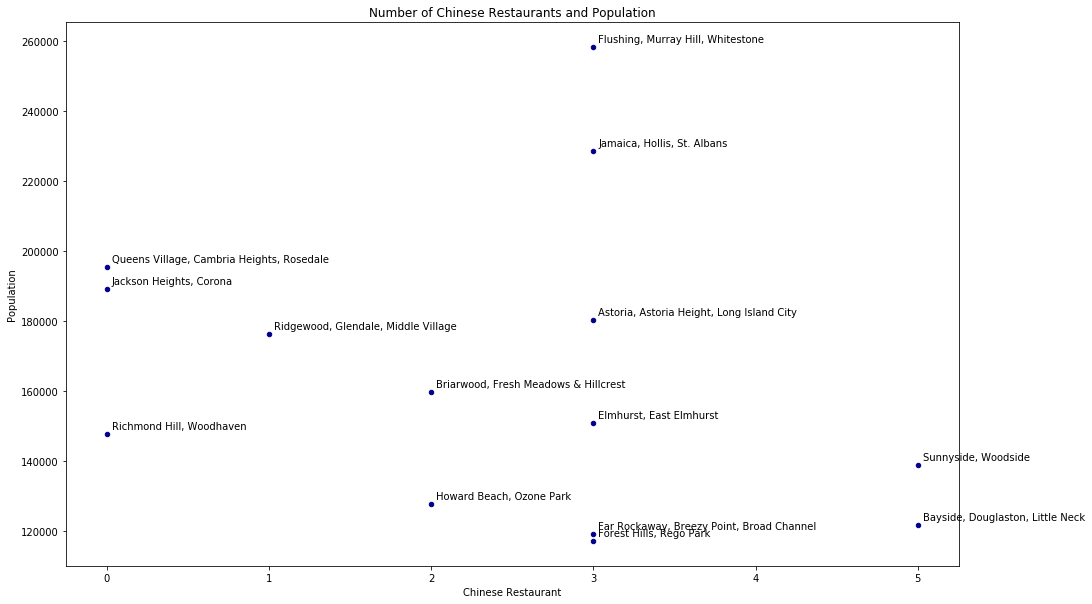

In [38]:
chinese_to_plot = queens_14neighborhoods_asian_restaurants[['Chinese Restaurant','Population']]
ax = chinese_to_plot.plot(kind='scatter', x='Chinese Restaurant', y='Population', figsize=(16, 10), color='darkblue')
for i, txt in enumerate(chinese_to_plot.axes[0].tolist()):
    ax.annotate(txt, (chinese_to_plot['Chinese Restaurant'][i],chinese_to_plot['Population'][i]), size=10, xytext=(5,5), ha='left', textcoords='offset points')
plt.title("Number of Chinese Restaurants and Population")

**Analysis of the above plot:**<br>
First, let's observe the demographics of Queens because this would play a big role of the Chinese and east Asian restaurant disbributions. According to the wikipedia of demographics of Queens, it says that "Asians are numerous throughout the borough but most concentrated in Northeastern and Central Queens in areas such as Flushing, Little Neck, Bayside, Fresh Meadows, Jamaica Estates, Elmhurst, Woodside, Richmond Hill, and Ozone Park." <br>
In the plot, there are 6, the maximum number of Chinese restaurants in the plot, in 'Bayside, Douglaston, and Little Neck'. This makes sense because Bayside and Little Neck is an area that many Asian people live. However, the population of Bayside, Douglaston and Little Neck is quite low compared to other neighborhoods. This indicates that there already could be enough Chinese restaurants. So, we would not recommend open a new Chinese restaurant here. The neighborhoods, 'Astoria, Astoria Height, Long Island City', 'Elmhurst, East Elmhurst', and 'Sunnyside, Woodside' are all areas that many Asian people live and it is reasonable that they have relatively higher number of Chinese restaurants. With a relatively low population in these areas, I would also not recommend to open a new Chinese restaurant in these three areas.<br>
The next group of neighborhoods, 'Flushing, Murrey Hill, Whitestone', 'Jamaica, Hillis, St. Albans', 'Ridgewood, Glendale, Middle Village', and 'Far Rockaway, Breezy Point, Broad Channel', all have 3 Chinese restaurants, but with very big difference of population. It is easy to observe that the bigger the population, the more restaurants needed. So, it is reasonable that I recommend open a new Chinese restaurant in the neighborhood 'Flushing, Murrey Hill, Whitestone' which has a huge population, 258,315. 'Jamaica, Hillis, St. Albans' is also a good area to open a new Chinese restaurant because of its relatively smalls number of Chinese restaurants and huge population.<br>
Among all the neighborhoods that have either 2 or 0 Chinese restaurants, only one neighborhood 'Richmond Hill, Woodhaven' was reported as a neighborhood with a lot of Asians. But the overall population, 147,541, is quite low compared to other neighborhoods. Therefore, this neighborhood would not be recommend open a new Chinese restaurant.<br>
Overall, according the analysis of the above plot, the top neighborhood to open a new Chinese restaurant is 'Flushing, Murrey Hill, Whitestone'.

## The following plot shows the number of total east Asian restaurants and population in different neighborhoods.

Text(0.5, 1.0, 'Number of east Asian Restaurants and Population')

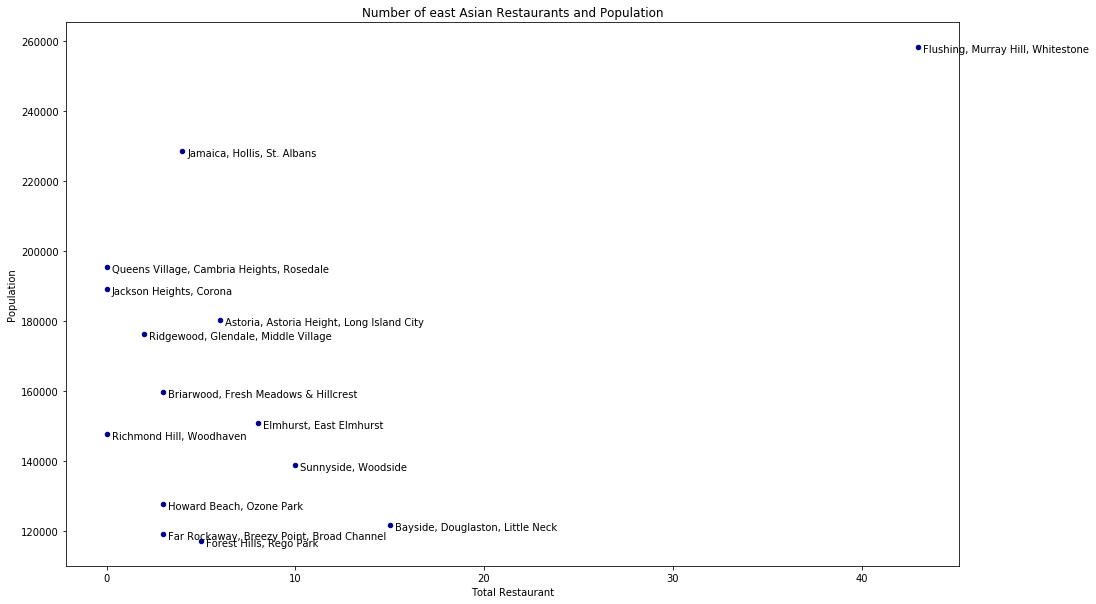

In [39]:
total_to_plot = queens_14neighborhoods_asian_restaurants[['Total Restaurant','Population']]
ax = total_to_plot.plot(kind='scatter', x='Total Restaurant', y='Population', figsize=(16, 10), color='darkblue')
for i, txt in enumerate(total_to_plot.axes[0].tolist()):
    ax.annotate(txt, (total_to_plot['Total Restaurant'][i],total_to_plot['Population'][i]), size=10, xytext=(5,-5), ha='left', textcoords='offset points')
plt.title("Number of east Asian Restaurants and Population")

**Analysis of the above plot:**<br>
Since this plot shows the relationship of east Asian restaurants and the population, I am able to see some commonalities to the plot showing the relationship of Chinese restaurant and population. However, I am able to see some interesting insights and differences from it.<br>
Not surprisingly, I see the neighborhood 'Flushing, Murray Hill, and Whitestone' with the biggest population has the biggest number which is 42 of east Asian restaurants. This number is far bigger than the number of east Asian restaurants in other neighborhoods. However, in our previous plot, the number of Chinese restaurant in this neighborhood was not the biggest one and it was close to other neighborhoods. Obseving the number of restaurants in our dataset, I find that there are totally 25 Korean restaurants in 'Flushing, Murray Hill, and Whitestone'. This contributes more than half of the east Asian restaurants in the neighborhood. This is an interesting observation that it shows that the number Chinese restaurant is not that big compared to other east Asian restaurants. This is the main reason that I generate the plot of the density of Chinese restaurants and population that is shown later.<br>
Looking at other neighborhoods, I see that 'Bayside, Douglaston, Little Neck' has a relativly bigger number of east Asian restaurants with a very low population which again shows this is not a good neighborhood to open a new Chinese restaurant.<br>
Almost all other neighborhoods have small number of east Asian restaurants and relatively low population except 'Jamaica, Hillis, St. Albans'. This neighborhood has 4 east Asian restaurants and a big population, 228,533. So, this neighborhood is also a good choice to open a new Chinese restaurant.
Overall, after observing the plot above, I recommend open a new Chinese restaurant in 'Flushing, Murray Hill, and Whitestone' or 'Jamaica, Hillis, St. Albans'.

## The following plot shows the density of Chinese restaurants among east Asian restaurants and population in different neighborhoods.
I analyze the density of Chinese restaurants among east Asian restaurants and the population to see if Chinese restaurants are taking a big or small portion of the restaurants in the neighborhoods.

In [40]:
# Create a new column 'Chinese/Total' to represent the density of Chinese restaurants among east Asian restaurants in each neighborhood.
queens_14neighborhoods_asian_restaurants['Chinese/Total'] = round((queens_14neighborhoods_asian_restaurants['Chinese Restaurant'] \
                                                                                /queens_14neighborhoods_asian_restaurants['Total Restaurant']),2) 
queens_14neighborhoods_asian_restaurants.fillna(0,inplace=True)
queens_14neighborhoods_asian_restaurants

,Cantonese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Filipino Restaurant,Hotpot Restaurant,Indonesian Restaurant,Japanese Restaurant,Korean Restaurant,Malay Restaurant,Shanghai Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Vietnamese Restaurant,Population,Total Restaurant,Chinese/Total
Neighborhood,,,,,,,,,,,,,,,,,
"Astoria, Astoria Height, Long Island City",0,3,0,0,0,0,0,2,1,0,0,0,0,0,180171,6,0.50
"Jackson Heights, Corona",0,0,0,0,0,0,0,0,0,0,0,0,0,0,189150,0,0.00
"Flushing, Murray Hill, Whitestone",1,3,1,1,0,6,0,1,26,1,1,2,0,0,258315,43,0.07
"Bayside, Douglaston, Little Neck",1,5,0,0,0,0,0,1,4,0,2,0,0,2,121623,15,0.33
"Queens Village, Cambria Heights, Rosedale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,195531,0,0.00
"Briarwood, Fresh Meadows & Hillcrest",0,2,1,0,0,0,0,0,0,0,0,0,0,0,159617,3,0.67
"Elmhurst, East Elmhurst",0,3,0,0,0,1,1,0,0,1,0,0,0,2,150886,8,0.38
"Forest Hills, Rego Park",0,3,0,0,0,0,0,1,0,0,1,0,0,0,117027,5,0.60
"Sunnyside, Woodside",0,5,0,0,4,0,0,1,0,0,0,0,0,0,138673,10,0.50


Text(0.5, 1.0, 'Density of Chinese Restaurants and Population')

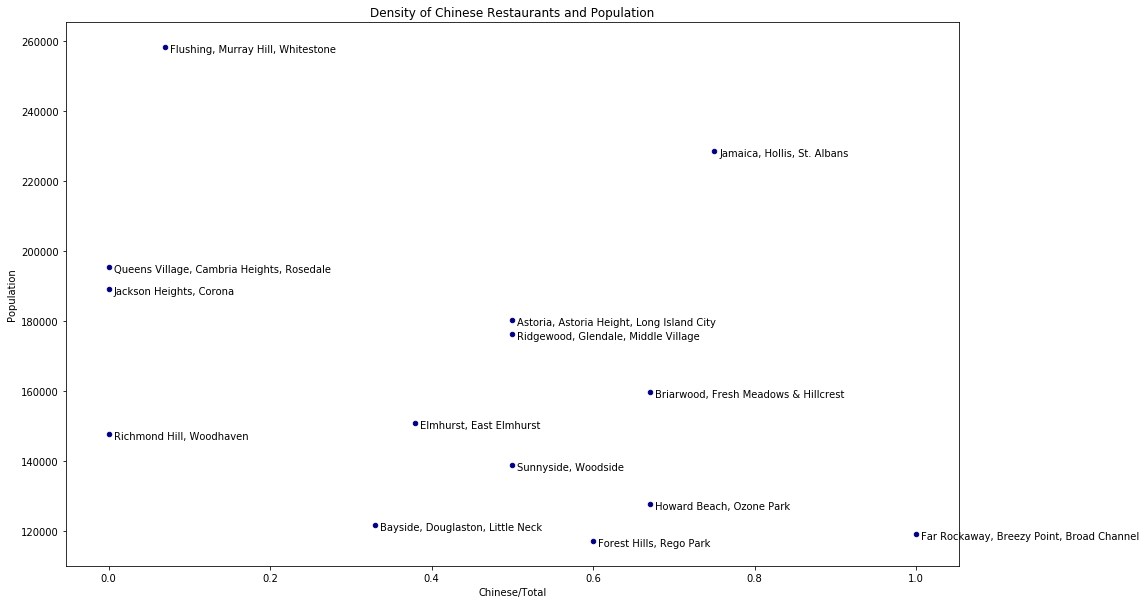

In [41]:
chinese_total_ratio = queens_14neighborhoods_asian_restaurants[['Chinese/Total','Population']]
ax = chinese_total_ratio.plot(kind='scatter', x='Chinese/Total', y='Population', figsize=(16, 10), color='darkblue')
for i, txt in enumerate(chinese_total_ratio.axes[0].tolist()):
    ax.annotate(txt, (chinese_total_ratio['Chinese/Total'][i],chinese_total_ratio['Population'][i]), size=10, xytext=(5,-5), ha='left', textcoords='offset points')
plt.title("Density of Chinese Restaurants and Population")

**Analysis of the above plot:**<br>
The above plot show the relationship of the density of Chinese retaurants among east Asian restaurants and the population. Generally, we would choose the place satisfies the following cratia:
1. The population is big.
2. The Asian population is big.
3. The density of Chinese restaurants is low, i.e., the number Chinese restaurants is relatively small compared to other east Asian restaurants.

Let's focus more on the neighborhoods that the ratio is lower than 0.5. A ratio above 0.5 indicates that more than half of the restaurants in the neighborhood are Chinese restaurants. So, the competition would be much tougher than other neighborhoods. And the residents may not need more.<br>
Among the neighborhoods with the ratio values lower than 0.5, all of them have much smaller population than 'Flushing, Murray Hill, and Whitestone'. Furthermore, 'Flushing, Murray Hill, and Whitestone' has a quite small ratio of 0.07. This implies that even though there are very many east Asian restaurants in this neighborhood, Chinese restaurants take a very small portion of them. Considering that 'Flushing, Murray Hill, and Whitestone' is a neighborhood that very many Asians live, I do recommend open a new Chinese restaurant in this neighborhood.

## Conclusion<br>
This project solves the problem which neighborhood to choose to open a new Chinese restaurant in the Queens borough, New York City. The project uses the venu data of neighborhoods of Queens brorough of New York City and the population of the neighborhoods from the official website of New York's Department of Health. The dataset from the two sources was cleaned, filtered, and combined for the visulization and analysis. Using the scattered plots generated, I am able to analyze the relations of the Chinese restaurants, the east Asian restaurants, and the populations in Queens's neighborhoods. Finally, the neighborhood 'Flushing, Murray Hill, and Whitestone' is recommended as the best choice to open a new Chinese restaurant.

## Future Work<br>

Since the limitions of the data that I am able to obtain from Foursquare and the Department of Health of NYC, I am not able to do more data understanding, data cleaning, model creation, data visulization, and analysis. For example, if we know the revenue of both the Chinese and east Asian restaurants, the numbers of Chinese population in Queens's neighborhoods, the Demographics of visitors to Queens borough, and so on, we would be able to anylize if the number of Chinese population has a linear regression relation with the number population although we assume this should be true, which neighborhood's Chinese restaurants have the highest revenue, and which neighborhoods have the biggest number of visitors, especially Chinese visitors. 